In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr

import warnings

warnings.simplefilter("ignore")

import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from sklearn.utils import shuffle
import tensorflow.keras.backend as kbackend
import tensorflow.keras.models
from keras.utils import np_utils
from keras.regularizers import l2

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils

import os
import sys

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

In [2]:
def basal_topology_func(x):
    b = 1.0 - 0.1*x
    return b

def solution(nx, nt, L, T, M, basal_topology_func):

    if len(M) != nx + 1:
        raise ValueError('M specified but len(M) != nx + 1')
        
    dx = L/nx
    dt = T/nt
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = np.maximum(h[:,i] - b, 0.)

        if not np.any(H[:,i]>=0.0):
            raise Exception("Something went wrong.")
            
    Volume = np.sum(H)*dx
    
    return H[int(nx/2),-1], h[int(nx/2),-1], Volume

L = 30.
T = 10.
nx = 300
nt = 12000
samples = 1000

M_samples = 0.01*np.random.rand(samples, nx+1)
H_samples = np.zeros((samples,1), dtype = np.float64)
Volume_samples = np.zeros((samples,1), dtype = np.float64)

for sample in range(samples):
    if (sample+1) % 100 == 0:
        print(f'Sample #{sample+1}', end='\r')
    H_samples[sample], _, Volume_samples[sample] = solution(nx, nt, L, T, M_samples[sample], basal_topology_func)

In [3]:
Layers = [{'size': 301, 'activation': None    , 'use_bias': None},
          {'size': 10 , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1  , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnected(M_samples, H_samples, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 500, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()
H_pred = best_model.predict(M_samples)

Train on 800 samples, validate on 200 samples
Epoch 1/500


2023-06-30 19:03:54.777082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-06-30 19:03:54.777142: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


650/800 [=======================>......] - ETA: 0s - loss: 7.5787e-04 - mae: 0.0226
Epoch 1: val_loss improved from inf to 0.00049, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 409us/sample - loss: 7.1368e-04 - mae: 0.0220 - val_loss: 4.9348e-04 - val_mae: 0.0186
Epoch 2/500
760/800 [===========================>..] - ETA: 0s - loss: 5.0373e-04 - mae: 0.0192
Epoch 2: val_loss did not improve from 0.00049
800/800 [==============================] - 0s 159us/sample - loss: 4.9941e-04 - mae: 0.0192 - val_loss: 5.0473e-04 - val_mae: 0.0181
Epoch 3/500
730/800 [==========================>...] - ETA: 0s - loss: 5.0453e-04 - mae: 0.0191
Epoch 3: val_loss improved from 0.00049 to 0.00049, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 188us/sample - loss: 4.9928e-04 - mae: 0.0189 - val_loss: 4.8598e-04 - val_mae: 0.0178
Epoch 4/500
750/800 [===========================>..] - ETA: 0s - loss:

750/800 [===========================>..] - ETA: 0s - loss: 1.1396e-04 - mae: 0.0085
Epoch 26: val_loss did not improve from 0.00018
800/800 [==============================] - 0s 165us/sample - loss: 1.1246e-04 - mae: 0.0085 - val_loss: 1.8521e-04 - val_mae: 0.0116
Epoch 27/500
390/800 [=============>................] - ETA: 0s - loss: 1.0083e-04 - mae: 0.0082
Epoch 27: val_loss improved from 0.00018 to 0.00016, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 175us/sample - loss: 1.0129e-04 - mae: 0.0081 - val_loss: 1.6474e-04 - val_mae: 0.0108
Epoch 28/500
720/800 [==========================>...] - ETA: 0s - loss: 8.9602e-05 - mae: 0.0075
Epoch 28: val_loss improved from 0.00016 to 0.00016, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 202us/sample - loss: 9.1348e-05 - mae: 0.0076 - val_loss: 1.5652e-04 - val_mae: 0.0105
Epoch 29/500
740/800 [==========================>...] - ETA: 

750/800 [===========================>..] - ETA: 0s - loss: 2.5286e-05 - mae: 0.0041
Epoch 52: val_loss improved from 0.00006 to 0.00006, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 194us/sample - loss: 2.5511e-05 - mae: 0.0041 - val_loss: 5.7772e-05 - val_mae: 0.0062
Epoch 53/500
790/800 [============================>.] - ETA: 0s - loss: 2.5261e-05 - mae: 0.0041
Epoch 53: val_loss did not improve from 0.00006
800/800 [==============================] - 0s 155us/sample - loss: 2.5233e-05 - mae: 0.0041 - val_loss: 6.3519e-05 - val_mae: 0.0065
Epoch 54/500
800/800 [==============================] - ETA: 0s - loss: 2.2838e-05 - mae: 0.0039
Epoch 54: val_loss improved from 0.00006 to 0.00006, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 173us/sample - loss: 2.2838e-05 - mae: 0.0039 - val_loss: 5.5160e-05 - val_mae: 0.0060
Epoch 55/500
400/800 [==============>...............] - ETA: 

Epoch 79/500
490/800 [=================>............] - ETA: 0s - loss: 1.7975e-05 - mae: 0.0034
Epoch 79: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 129us/sample - loss: 1.8797e-05 - mae: 0.0035 - val_loss: 4.7065e-05 - val_mae: 0.0054
Epoch 80/500
430/800 [===============>..............] - ETA: 0s - loss: 1.9380e-05 - mae: 0.0035
Epoch 80: val_loss improved from 0.00004 to 0.00004, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 159us/sample - loss: 1.9621e-05 - mae: 0.0035 - val_loss: 4.2380e-05 - val_mae: 0.0052
Epoch 81/500
410/800 [==============>...............] - ETA: 0s - loss: 1.6425e-05 - mae: 0.0033
Epoch 81: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 1.8537e-05 - mae: 0.0035 - val_loss: 4.2753e-05 - val_mae: 0.0052
Epoch 82/500
720/800 [==========================>...] - ETA: 0s - loss: 1.9888e-05 - mae: 0.0036
Epoch 82: 

Epoch 108/500
420/800 [==============>...............] - ETA: 0s - loss: 1.5919e-05 - mae: 0.0032
Epoch 108: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 1.9209e-05 - mae: 0.0035 - val_loss: 4.2464e-05 - val_mae: 0.0051
Epoch 109/500
410/800 [==============>...............] - ETA: 0s - loss: 1.8261e-05 - mae: 0.0035
Epoch 109: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.8835e-05 - mae: 0.0035 - val_loss: 5.5563e-05 - val_mae: 0.0059
Epoch 110/500
800/800 [==============================] - ETA: 0s - loss: 2.1059e-05 - mae: 0.0037
Epoch 110: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 2.1059e-05 - mae: 0.0037 - val_loss: 4.7847e-05 - val_mae: 0.0055
Epoch 111/500
610/800 [=====================>........] - ETA: 0s - loss: 1.6789e-05 - mae: 0.0033
Epoch 111: val_loss did not improve from 0.00004
800/800 [====

780/800 [============================>.] - ETA: 0s - loss: 1.9076e-05 - mae: 0.0035
Epoch 137: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.9439e-05 - mae: 0.0035 - val_loss: 4.4848e-05 - val_mae: 0.0053
Epoch 138/500
800/800 [==============================] - ETA: 0s - loss: 1.9237e-05 - mae: 0.0035
Epoch 138: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.9237e-05 - mae: 0.0035 - val_loss: 4.4623e-05 - val_mae: 0.0053
Epoch 139/500
800/800 [==============================] - ETA: 0s - loss: 1.8073e-05 - mae: 0.0034
Epoch 139: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.8073e-05 - mae: 0.0034 - val_loss: 5.5076e-05 - val_mae: 0.0059
Epoch 140/500
450/800 [===============>..............] - ETA: 0s - loss: 1.6538e-05 - mae: 0.0033
Epoch 140: val_loss did not improve from 0.00004
800/800 [==================

800/800 [==============================] - ETA: 0s - loss: 1.7745e-05 - mae: 0.0034
Epoch 166: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.7745e-05 - mae: 0.0034 - val_loss: 4.3233e-05 - val_mae: 0.0052
Epoch 167/500
460/800 [================>.............] - ETA: 0s - loss: 1.9758e-05 - mae: 0.0036
Epoch 167: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 135us/sample - loss: 1.8442e-05 - mae: 0.0034 - val_loss: 4.7527e-05 - val_mae: 0.0055
Epoch 168/500
430/800 [===============>..............] - ETA: 0s - loss: 1.6879e-05 - mae: 0.0033
Epoch 168: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.8286e-05 - mae: 0.0034 - val_loss: 4.3336e-05 - val_mae: 0.0052
Epoch 169/500
430/800 [===============>..............] - ETA: 0s - loss: 1.7908e-05 - mae: 0.0034
Epoch 169: val_loss did not improve from 0.00004
800/800 [==================

710/800 [=========================>....] - ETA: 0s - loss: 1.6911e-05 - mae: 0.0033
Epoch 195: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 1.7273e-05 - mae: 0.0033 - val_loss: 4.9697e-05 - val_mae: 0.0056
Epoch 196/500
440/800 [===============>..............] - ETA: 0s - loss: 1.7911e-05 - mae: 0.0034
Epoch 196: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 2.0094e-05 - mae: 0.0036 - val_loss: 4.4121e-05 - val_mae: 0.0052
Epoch 197/500
410/800 [==============>...............] - ETA: 0s - loss: 1.7906e-05 - mae: 0.0034
Epoch 197: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.7784e-05 - mae: 0.0034 - val_loss: 4.5575e-05 - val_mae: 0.0053
Epoch 198/500
750/800 [===========================>..] - ETA: 0s - loss: 1.9109e-05 - mae: 0.0035
Epoch 198: val_loss did not improve from 0.00004
800/800 [==================

700/800 [=========================>....] - ETA: 0s - loss: 1.7838e-05 - mae: 0.0034
Epoch 224: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 168us/sample - loss: 1.7727e-05 - mae: 0.0034 - val_loss: 4.6542e-05 - val_mae: 0.0054
Epoch 225/500
720/800 [==========================>...] - ETA: 0s - loss: 1.7168e-05 - mae: 0.0033
Epoch 225: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 164us/sample - loss: 1.7272e-05 - mae: 0.0033 - val_loss: 4.8296e-05 - val_mae: 0.0055
Epoch 226/500
710/800 [=========================>....] - ETA: 0s - loss: 2.2001e-05 - mae: 0.0037
Epoch 226: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 167us/sample - loss: 2.1967e-05 - mae: 0.0037 - val_loss: 4.4941e-05 - val_mae: 0.0053
Epoch 227/500
780/800 [============================>.] - ETA: 0s - loss: 1.8017e-05 - mae: 0.0034
Epoch 227: val_loss did not improve from 0.00004
800/800 [==================

440/800 [===============>..............] - ETA: 0s - loss: 2.2088e-05 - mae: 0.0038
Epoch 253: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 2.1020e-05 - mae: 0.0037 - val_loss: 4.5785e-05 - val_mae: 0.0054
Epoch 254/500
440/800 [===============>..............] - ETA: 0s - loss: 1.6755e-05 - mae: 0.0033
Epoch 254: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.7634e-05 - mae: 0.0034 - val_loss: 4.3340e-05 - val_mae: 0.0052
Epoch 255/500
720/800 [==========================>...] - ETA: 0s - loss: 2.2482e-05 - mae: 0.0038
Epoch 255: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 171us/sample - loss: 2.2657e-05 - mae: 0.0038 - val_loss: 4.3256e-05 - val_mae: 0.0052
Epoch 256/500
760/800 [===========================>..] - ETA: 0s - loss: 2.2354e-05 - mae: 0.0038
Epoch 256: val_loss did not improve from 0.00004
800/800 [==================

450/800 [===============>..............] - ETA: 0s - loss: 1.6783e-05 - mae: 0.0032
Epoch 282: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.8022e-05 - mae: 0.0034 - val_loss: 4.4620e-05 - val_mae: 0.0053
Epoch 283/500
460/800 [================>.............] - ETA: 0s - loss: 1.7280e-05 - mae: 0.0034
Epoch 283: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.7336e-05 - mae: 0.0034 - val_loss: 4.3921e-05 - val_mae: 0.0052
Epoch 284/500
440/800 [===============>..............] - ETA: 0s - loss: 1.6910e-05 - mae: 0.0033
Epoch 284: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 1.7262e-05 - mae: 0.0033 - val_loss: 4.3321e-05 - val_mae: 0.0052
Epoch 285/500
430/800 [===============>..............] - ETA: 0s - loss: 1.6462e-05 - mae: 0.0032
Epoch 285: val_loss did not improve from 0.00004
800/800 [==================

460/800 [================>.............] - ETA: 0s - loss: 1.6572e-05 - mae: 0.0033
Epoch 311: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.8501e-05 - mae: 0.0035 - val_loss: 4.4954e-05 - val_mae: 0.0053
Epoch 312/500
450/800 [===============>..............] - ETA: 0s - loss: 1.8828e-05 - mae: 0.0035
Epoch 312: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.8892e-05 - mae: 0.0035 - val_loss: 4.2866e-05 - val_mae: 0.0052
Epoch 313/500
470/800 [================>.............] - ETA: 0s - loss: 1.7498e-05 - mae: 0.0034
Epoch 313: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.8056e-05 - mae: 0.0034 - val_loss: 4.2804e-05 - val_mae: 0.0052
Epoch 314/500
480/800 [=================>............] - ETA: 0s - loss: 1.6060e-05 - mae: 0.0032
Epoch 314: val_loss did not improve from 0.00004
800/800 [==================

480/800 [=================>............] - ETA: 0s - loss: 2.0388e-05 - mae: 0.0037
Epoch 340: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 127us/sample - loss: 1.8116e-05 - mae: 0.0034 - val_loss: 4.6223e-05 - val_mae: 0.0054
Epoch 341/500
480/800 [=================>............] - ETA: 0s - loss: 2.0760e-05 - mae: 0.0037
Epoch 341: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 2.0526e-05 - mae: 0.0036 - val_loss: 4.3134e-05 - val_mae: 0.0052
Epoch 342/500
400/800 [==============>...............] - ETA: 0s - loss: 1.5916e-05 - mae: 0.0031
Epoch 342: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.7350e-05 - mae: 0.0033 - val_loss: 4.3290e-05 - val_mae: 0.0052
Epoch 343/500
480/800 [=================>............] - ETA: 0s - loss: 1.7997e-05 - mae: 0.0034
Epoch 343: val_loss did not improve from 0.00004
800/800 [==================

430/800 [===============>..............] - ETA: 0s - loss: 1.6797e-05 - mae: 0.0033
Epoch 369: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.7601e-05 - mae: 0.0034 - val_loss: 4.6454e-05 - val_mae: 0.0054
Epoch 370/500
390/800 [=============>................] - ETA: 0s - loss: 1.8696e-05 - mae: 0.0035
Epoch 370: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.7485e-05 - mae: 0.0033 - val_loss: 4.3431e-05 - val_mae: 0.0052
Epoch 371/500
480/800 [=================>............] - ETA: 0s - loss: 1.6901e-05 - mae: 0.0033
Epoch 371: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.7461e-05 - mae: 0.0033 - val_loss: 4.3283e-05 - val_mae: 0.0052
Epoch 372/500
410/800 [==============>...............] - ETA: 0s - loss: 1.9415e-05 - mae: 0.0035
Epoch 372: val_loss did not improve from 0.00004
800/800 [==================

430/800 [===============>..............] - ETA: 0s - loss: 1.6885e-05 - mae: 0.0033
Epoch 398: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.7785e-05 - mae: 0.0034 - val_loss: 4.4020e-05 - val_mae: 0.0053
Epoch 399/500
420/800 [==============>...............] - ETA: 0s - loss: 1.7769e-05 - mae: 0.0033
Epoch 399: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.8933e-05 - mae: 0.0034 - val_loss: 5.0441e-05 - val_mae: 0.0057
Epoch 400/500
420/800 [==============>...............] - ETA: 0s - loss: 1.7916e-05 - mae: 0.0034
Epoch 400: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.8618e-05 - mae: 0.0034 - val_loss: 4.3863e-05 - val_mae: 0.0052
Epoch 401/500
420/800 [==============>...............] - ETA: 0s - loss: 1.7810e-05 - mae: 0.0034
Epoch 401: val_loss did not improve from 0.00004
800/800 [==================

520/800 [==================>...........] - ETA: 0s - loss: 1.6162e-05 - mae: 0.0032
Epoch 427: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 113us/sample - loss: 1.6281e-05 - mae: 0.0032 - val_loss: 4.3403e-05 - val_mae: 0.0052
Epoch 428/500
580/800 [====================>.........] - ETA: 0s - loss: 1.7338e-05 - mae: 0.0033
Epoch 428: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 101us/sample - loss: 1.7899e-05 - mae: 0.0033 - val_loss: 4.3146e-05 - val_mae: 0.0052
Epoch 429/500
590/800 [=====================>........] - ETA: 0s - loss: 1.8421e-05 - mae: 0.0034
Epoch 429: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 101us/sample - loss: 1.7365e-05 - mae: 0.0033 - val_loss: 5.4175e-05 - val_mae: 0.0059
Epoch 430/500
630/800 [======================>.......] - ETA: 0s - loss: 1.7848e-05 - mae: 0.0034
Epoch 430: val_loss did not improve from 0.00004
800/800 [==================

450/800 [===============>..............] - ETA: 0s - loss: 1.8803e-05 - mae: 0.0035
Epoch 456: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.8640e-05 - mae: 0.0035 - val_loss: 4.2911e-05 - val_mae: 0.0052
Epoch 457/500
450/800 [===============>..............] - ETA: 0s - loss: 1.7131e-05 - mae: 0.0033
Epoch 457: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.7265e-05 - mae: 0.0033 - val_loss: 4.4676e-05 - val_mae: 0.0053
Epoch 458/500
480/800 [=================>............] - ETA: 0s - loss: 1.7405e-05 - mae: 0.0034
Epoch 458: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.6959e-05 - mae: 0.0033 - val_loss: 4.7153e-05 - val_mae: 0.0054
Epoch 459/500
480/800 [=================>............] - ETA: 0s - loss: 1.6436e-05 - mae: 0.0032
Epoch 459: val_loss did not improve from 0.00004
800/800 [==================

490/800 [=================>............] - ETA: 0s - loss: 2.0521e-05 - mae: 0.0037
Epoch 485: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 126us/sample - loss: 1.9337e-05 - mae: 0.0035 - val_loss: 4.5324e-05 - val_mae: 0.0053
Epoch 486/500
490/800 [=================>............] - ETA: 0s - loss: 2.4410e-05 - mae: 0.0039
Epoch 486: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 125us/sample - loss: 2.3582e-05 - mae: 0.0039 - val_loss: 4.7302e-05 - val_mae: 0.0055
Epoch 487/500
440/800 [===============>..............] - ETA: 0s - loss: 2.1760e-05 - mae: 0.0038
Epoch 487: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 2.0113e-05 - mae: 0.0036 - val_loss: 4.6490e-05 - val_mae: 0.0054
Epoch 488/500
460/800 [================>.............] - ETA: 0s - loss: 1.5522e-05 - mae: 0.0031
Epoch 488: val_loss did not improve from 0.00004
800/800 [==================

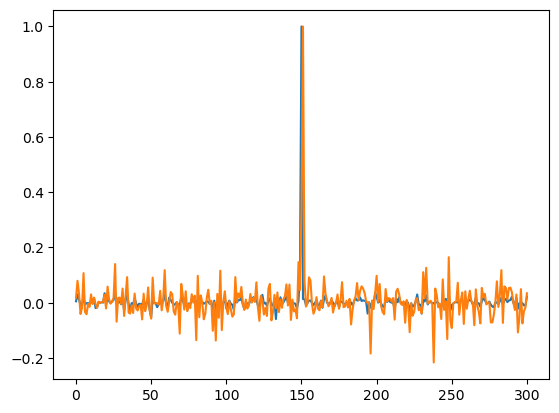

In [4]:
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
X = XAIR(best_model, 'lrp.z', M_samples, normalizeDict)
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [ ]:
def regression_letzgus(model, input_, y_ref, step_width=0.00005, max_it=10e4, method = "flood"):
    
    ### Finding a_ref for a given y_ref
    
    if method == "flood":
        
        model_part = Model(inputs=model.input,
                          outputs=model.layers[-2].output)
        a_ref = model_part.predict(input_)[0,:]
        a_ref = a_ref[:, np.newaxis]
        update = np.ones(a_ref.shape) * step_width
        
        y = model.predict(input_)
        
        counter = 0
        
        if y > y_ref:
            
            while y >= y_ref:
                
                a_ref = np.maximum(np.zeros(a_ref.shape),a_ref-update)
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
        else:
            
            while y <= y_ref:
                
                a_ref = np.maximum(np.zeros(a_ref.shape),a_ref+update)
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
                    
    else: 
        
        raise ValueError("The only methods available are : flood")
        
    return a_ref

def triplicated_model(best_model, a_ref):
    
    # get weights and biases
    W_in = best_model.layers[-2].get_weights()[0]
    W_out = best_model.layers[-1].get_weights()[0]
    bias_in = best_model.layers[-2].get_weights()[1]

    inputs = Input(shape=(nx+1,))

    # layer_dict = dict([(layer.name, layer) for layer in model.layers[:-2]])
    # weights = layer_dict['some_name'].get_weights()

    dense11 = Dense(10, activation='relu', name='dense11')
    dense12 = Dense(10, activation='relu', name='dense12')
    dense13 = Dense(10, activation='relu', name='dense13')
    dense21 = Dense(1, activation='linear', use_bias=False, name='dense21')
    dense22 = Dense(1, activation='linear', use_bias=False, name='dense22')
    dense23 = Dense(1, activation='linear', use_bias=False, name='dense23')

    x1 = dense11(inputs)
    x2 = dense12(inputs)
    x3 = dense13(inputs)

    x1 = dense21(x1)
    x2 = dense22(x2)
    x3 = dense23(x3)

    model = keras.Model(inputs=inputs, outputs=x1+x2+x3) 
    
    #     def getLayerIndexByName(model, layername):
    #         for idx, layer in enumerate(model.layers):
    #             if layer.name == layername:
    #                 return idx
    #         raise Exception(f"layername: {layername} not found.")
            
    model.layers[getLayerIndexByName(model, 'dense11')].set_weights([W_in, bias_in-a_ref[:,0]])
    model.layers[getLayerIndexByName(model, 'dense12')].set_weights([-W_in, -bias_in])                 
    model.layers[getLayerIndexByName(model, 'dense13')].set_weights([-W_in, -bias_in+a_ref[:,0]])
    
    model.layers[getLayerIndexByName(model, 'dense21')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense22')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense23')].set_weights([-W_out])
    
    model.compile(loss='mse', optimizer='adam',metrics=['mae'])
    
    return model

In [ ]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y / 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, index], y_ref)

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
tri_model = triplicated_model(model_reg, a_ref)
y_reg = tri_model.predict(M_samples[np.newaxis, index])


y_ref, y-y_reg, y, y_reg

In [ ]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y * 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, index], y_ref)

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
tri_model = triplicated_model(model_reg, a_ref)
y_reg = tri_model.predict(M_samples[np.newaxis, index])

y_ref, y-y_reg, y, y_reg

In [ ]:
def triplicated_model_LRP_compatible(best_model, a_ref):
    
    # get weights and biases
    W_in = best_model.layers[-2].get_weights()[0]
    W_out = best_model.layers[-1].get_weights()[0]
    bias_in = best_model.layers[-2].get_weights()[1]

    inputs = Input(shape=(nx+1,))

    # layer_dict = dict([(layer.name, layer) for layer in model.layers[:-2]])
    # weights = layer_dict['some_name'].get_weights()

    dense11 = Dense(10, activation='relu', name='dense11')
    dense12 = Dense(10, activation='relu', name='dense12')
    dense13 = Dense(10, activation='relu', name='dense13')
    dense21 = Dense(1, activation='linear', use_bias=False, name='dense21')
    dense22 = Dense(1, activation='linear', use_bias=False, name='dense22')
    dense23 = Dense(1, activation='linear', use_bias=False, name='dense23')

    x1 = dense11(inputs)
    x2 = dense12(inputs)
    x3 = dense13(inputs)

    x1 = dense21(x1)
    x2 = dense22(x2)
    x3 = dense23(x3)

    model1 = keras.Model(inputs=inputs, outputs=x1)
    model2 = keras.Model(inputs=inputs, outputs=x2) 
    model3 = keras.Model(inputs=inputs, outputs=x3) 
            
    model1.layers[getLayerIndexByName(model1, 'dense11')].set_weights([W_in, bias_in-a_ref[:,0]])
    model2.layers[getLayerIndexByName(model2, 'dense12')].set_weights([-W_in, -bias_in])                 
    model3.layers[getLayerIndexByName(model3, 'dense13')].set_weights([-W_in, -bias_in+a_ref[:,0]])
    
    model1.layers[getLayerIndexByName(model1, 'dense21')].set_weights([W_out])
    model2.layers[getLayerIndexByName(model2, 'dense22')].set_weights([W_out])
    model3.layers[getLayerIndexByName(model3, 'dense23')].set_weights([-W_out])
    
    model1.compile(loss='mse', optimizer='adam',metrics=['mae'])
    model2.compile(loss='mse', optimizer='adam',metrics=['mae'])
    model3.compile(loss='mse', optimizer='adam',metrics=['mae'])
    
    return model1, model2, model3

In [ ]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y * 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], y_ref)

model1, model2, model3 = triplicated_model_LRP_compatible(best_model, a_ref)
y1 = model1.predict(M_samples[np.newaxis, index])
y2 = model1.predict(M_samples[np.newaxis, index])
y3 = model1.predict(M_samples[np.newaxis, index])

analyzer_gradient1 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model1)
analyzer_gradient2 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model2)
analyzer_gradient3 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model3)
a1 = np.zeros((samples, nx+1), dtype = np.float64)
a2 = np.zeros((samples, nx+1), dtype = np.float64)
a3 = np.zeros((samples, nx+1), dtype = np.float64)
a  = np.zeros((samples, nx+1), dtype = np.float64)

for sample in range(samples):
    a1[sample] = analyzer_gradient1.analyze(M_samples[sample][np.newaxis,:])
    a2[sample] = analyzer_gradient2.analyze(M_samples[sample][np.newaxis,:])
    a3[sample] = analyzer_gradient3.analyze(M_samples[sample][np.newaxis,:])
    a[sample]  = a1[sample] + a2[sample] + a3[sample]
    a[sample]  = a[sample] / np.max(np.abs(a[sample]))
    
y, y_ref, y-(y1+y2+y3)

In [ ]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 0
plt.plot(a[index])
H_samples[index]-y_ref

In [ ]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 1
plt.plot(a[index])
H_samples[index]-y_ref

In [ ]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 100
plt.plot(a[index])
H_samples[index]-y_ref

In [ ]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y / 3.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], y_ref)

model1, model2, model3 = triplicated_model_LRP_compatible(best_model, a_ref)
y1 = model1.predict(M_samples[np.newaxis, index])
y2 = model2.predict(M_samples[np.newaxis, index])
y3 = model3.predict(M_samples[np.newaxis, index])

analyzer_gradient1 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model1)
analyzer_gradient2 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model2)
analyzer_gradient3 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model3)
a1 = np.zeros((samples, nx+1), dtype = np.float64)
a2 = np.zeros((samples, nx+1), dtype = np.float64)
a3 = np.zeros((samples, nx+1), dtype = np.float64)
a  = np.zeros((samples, nx+1), dtype = np.float64)

for sample in range(samples):
    a1[sample] = analyzer_gradient1.analyze(M_samples[sample][np.newaxis,:])
    a2[sample] = analyzer_gradient2.analyze(M_samples[sample][np.newaxis,:])
    a3[sample] = analyzer_gradient3.analyze(M_samples[sample][np.newaxis,:])
    a[sample]  = a1[sample] + a2[sample] + a3[sample]
    a[sample]  = a[sample] / np.max(np.abs(a[sample]))
    
y, y_ref, y-(y1+y2+y3)

In [ ]:
index = 0
plt.plot(a[index])
H_samples[index]-y_ref

In [ ]:
index = 1
plt.plot(a[index])
H_samples[index]-y_ref

In [ ]:
index = 2
plt.plot(a[index])
H_samples[index]-y_ref